In [1]:
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, logging
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_json("https://raw.githubusercontent.com/kiendoo4/final-project/main/dataset/Final_dataset.json")
print(data)

                full_name  gender
0           Ngô Xuân Tùng       1
1       Bùi Dương Thảo Vy       0
2             Lưu Thế Huy       1
3          Nguyễn Thị Vân       0
4         Dương Minh Long       1
...                   ...     ...
28796    Huỳnh Thu Phương       0
28797      Mai Nguyệt Lan       0
28798       Hà Thanh Ngân       0
28799  Phan Thị Tuyết Nhi       0
28800    Vũ Hoàng Thúy Vy       0

[28801 rows x 2 columns]


In [3]:
s1 = u'ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ'
s0 = u'AAAAEEEIIOOOOUUYaaaaeeeiioooouuyAaDdIiUuOoUuAaAaAaAaAaAaAaAaAaAaAaAaEeEeEeEeEeEeEeEeIiIiOoOoOoOoOoOoOoOoOoOoOoOoUuUuUuUuUuUuUuYyYyYyYy'
def remove_accents(input_str):
	s = ''
	for c in input_str:
		if c in s1:
			s += s0[s1.index(c)]
		else:
			s += c
	return s.lower()

In [4]:
data['full_name'] = data['full_name'].apply(remove_accents)

In [5]:
male = 0
female = 0
other = 0
for line in data["gender"]:
  if line == 1:
    male += 1
  elif line == 0:
    female += 1
  else:
    print(line)
    other += 1
print("Number of males, females and others in data: %s, %s, %s" % (male, female, other))
print("Length of data: %s" % len(data["gender"]))

Number of males, females and others in data: 16613, 12188, 0
Length of data: 28801


In [6]:
name_counts = data['full_name'].value_counts()
unique_names = name_counts[name_counts == 1].index
data = data[data['full_name'].isin(unique_names)]
print(data)

                  full_name  gender
1         bui duong thao vy       0
2               luu the huy       1
4           duong minh long       1
5            tran mai khanh       0
6      nguyen thi hong diep       0
...                     ...     ...
28794    pham doan bao chau       0
28796      huynh thu phuong       0
28797        mai nguyet lan       0
28798         ha thanh ngan       0
28800      vu hoang thuy vy       0

[18598 rows x 2 columns]


In [7]:
X = data["full_name"]
y = data["gender"]

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

X_train = X
y_train = y

In [11]:
phobert = AutoModel.from_pretrained("./generative_model/phobert_pretrain")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")
X_train_encoded = tokenizer.batch_encode_plus(
    X_train.tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
X_test_encoded = tokenizer.batch_encode_plus(
    X_test.tolist(),
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
print(X_train_encoded)

{'input_ids': tensor([[    0,  3763,  1111,  ...,     1,     1,     1],
        [    0,  3198,  1656,  ...,     1,     1,     1],
        [    0,  6190,  2662,  ...,     1,     1,     1],
        ...,
        [    0,  3189, 27497,  ...,     1,     1,     1],
        [    0,   953,  2106,  ...,     1,     1,     1],
        [    0, 21639,  6425,  ...,     1,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [12]:
with torch.no_grad():
    X_train_embeddings = phobert(
        input_ids=X_train_encoded['input_ids'],
        attention_mask=X_train_encoded['attention_mask']
    ).pooler_output
    X_test_embeddings = phobert(
        input_ids=X_test_encoded['input_ids'],
        attention_mask=X_test_encoded['attention_mask']
    ).pooler_output

In [13]:
X_train_embeddings = X_train_embeddings.cpu().numpy()
X_test_embeddings = X_test_embeddings.cpu().numpy()
print(type(X_train_embeddings))

<class 'numpy.ndarray'>


In [14]:
from sklearn.neural_network import MLPClassifier

In [15]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 32),max_iter=1000, random_state=42)
mlp.fit(X_train_embeddings, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test_embeddings)

# Evaluate the model

print(classification_report(y_test, y_pred, digits = 5))
print("Precision score of using Logistic Regression:", precision_score(y_test, y_pred, average='macro'))
print("Recall score of using Logistic Regression:", recall_score(y_test, y_pred, average='macro'))
print("F1-score of using Logistic Regression:", f1_score(y_test, y_pred, average='macro'))

              precision    recall  f1-score   support

           0    0.99937   1.00000   0.99969      1587
           1    1.00000   0.99953   0.99977      2133

    accuracy                        0.99973      3720
   macro avg    0.99969   0.99977   0.99973      3720
weighted avg    0.99973   0.99973   0.99973      3720

Precision score of using Logistic Regression: 0.9996851385390428
Recall score of using Logistic Regression: 0.9997655883731833
F1-score of using Logistic Regression: 0.9997252863907838


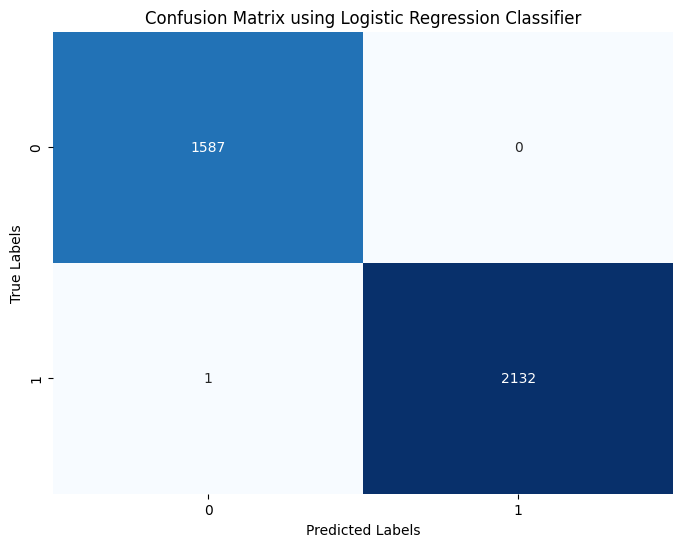

In [16]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix using Logistic Regression Classifier")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [17]:
data_test = ["le thanh long"]
X_test_encoded = tokenizer.batch_encode_plus(
    data_test,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
with torch.no_grad():
    X_test_embeddings = phobert(
        input_ids=X_test_encoded['input_ids'],
        attention_mask=X_test_encoded['attention_mask']
    ).pooler_output
X_test_embeddings = X_test_embeddings.cpu().numpy()
mlp.predict(X_test_embeddings)

array([1])

In [18]:
from joblib import load, dump

In [19]:
dump(mlp, "./name_cls.joblib")
load_model = load('./name_cls.joblib')

In [20]:
data_test = ["cao thanh duy"]
X_test_encoded = tokenizer.batch_encode_plus(
    data_test,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors="pt"
)
with torch.no_grad():
    X_test_embeddings = phobert(
        input_ids=X_test_encoded['input_ids'],
        attention_mask=X_test_encoded['attention_mask']
    ).pooler_output
X_test_embeddings = X_test_embeddings.cpu().numpy()
load_model.predict(X_test_embeddings)

array([1])